Different filtering methods will be tested and evaluated by randomly assigning samples to artificial classes, ensuring different project origins.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

## 1. No filtering

See modelling.ipynb

## 2. Filtering reoccuring proteins

In [2]:
data = pd.read_csv("/home/compomics/Sam/git/python/master_thesis/Atlas_creation/pooled_proteome_nsaf_1.csv")
data = data.pivot(index = "assay_id", columns = "uniprot_id", values = "NSAF")
metadata = pd.read_csv("/home/compomics/Sam/git/python/master_thesis/Atlas_creation/metadata_NSAF_atlas.csv")
dataset = pd.merge(data, metadata[["assay_id", "tissue_type", "PXD_accession"]], on = "assay_id", right_index=True)
#Left out due to not being pooled, due to not all the pool files being available
dataset = dataset[dataset.PXD_accession != "PXD009149"]
#Left out due to <10 protein ids
'''
assay_id    prot_ids
32491       7
32492       4
32493       6
'''
dataset = dataset[~dataset.index.isin([32491, 32492, 32493])]

dataset.reset_index(inplace=True)
assay_ids = dataset.pop("assay_id")
dataset = dataset.loc[:, ~dataset.columns.isin("tissue_type PXD_accession".split())]
metadata = metadata[metadata['assay_id'].isin(assay_ids)].reset_index(drop = True)

In [24]:
dataset.notna().sum(axis = 1)

0      8127
1      8111
2      8065
3      8001
4      1320
       ... 
505    3345
506    3767
507    3472
508    3014
509    2148
Length: 510, dtype: int64

In [37]:
# Filtering reoccuring proteins functions
def _identify_reoccured_proteins(subset, percentage_reoccurence):
    reoccuring_proteins = subset.notna().sum() / len(subset)
    result = reoccuring_proteins[reoccuring_proteins >= percentage_reoccurence].index.tolist()
    return result

def filter_proteins(dataset: pd.DataFrame, labels: pd.Series, percentage_reoccurence: float, info = False):
    counts_before_filtering = dataset.notna().sum(axis = 1)
    dataset_copy = dataset.copy()
    for label in labels.unique():
        label_indeces = labels[labels == label].index
        subset = dataset_copy.loc[dataset_copy.index.isin(label_indeces)]

        reoccuring_proteins = _identify_reoccured_proteins(subset=subset, percentage_reoccurence=percentage_reoccurence)
        dataset_copy.loc[dataset_copy.index.isin(label_indeces), ~dataset_copy.columns.isin(reoccuring_proteins)] = np.NaN

    counts_after_filtering = dataset_copy.notna().sum(axis = 1)
    dropped = counts_before_filtering-counts_after_filtering
    merged_info = pd.concat([counts_before_filtering, counts_after_filtering, dropped], axis = 1)
    merged_info.rename(columns = {0: "before", 1: "after", 2: "proteins_lost"}, inplace = True)
    
    if info:
        return dataset_copy, merged_info
    return dataset_copy


### 2.1 On complete dataset

In [54]:
filtered_dataset, info = filter_proteins(dataset=dataset, labels = metadata.tissue_type, percentage_reoccurence= 0.5, info = True)

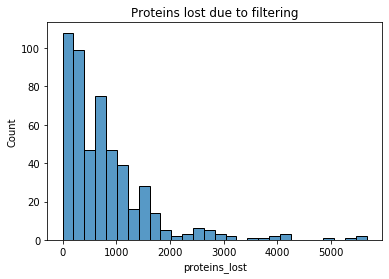

In [58]:
plt.title("Proteins lost due to filtering")
sns.histplot(info.proteins_lost)

In [71]:
sieved_proteins = filtered_dataset.isna().sum()[filtered_dataset.isna().sum()==510].index
filtered_dataset = filtered_dataset.loc[:,~filtered_dataset.columns.isin(sieved_proteins)]

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


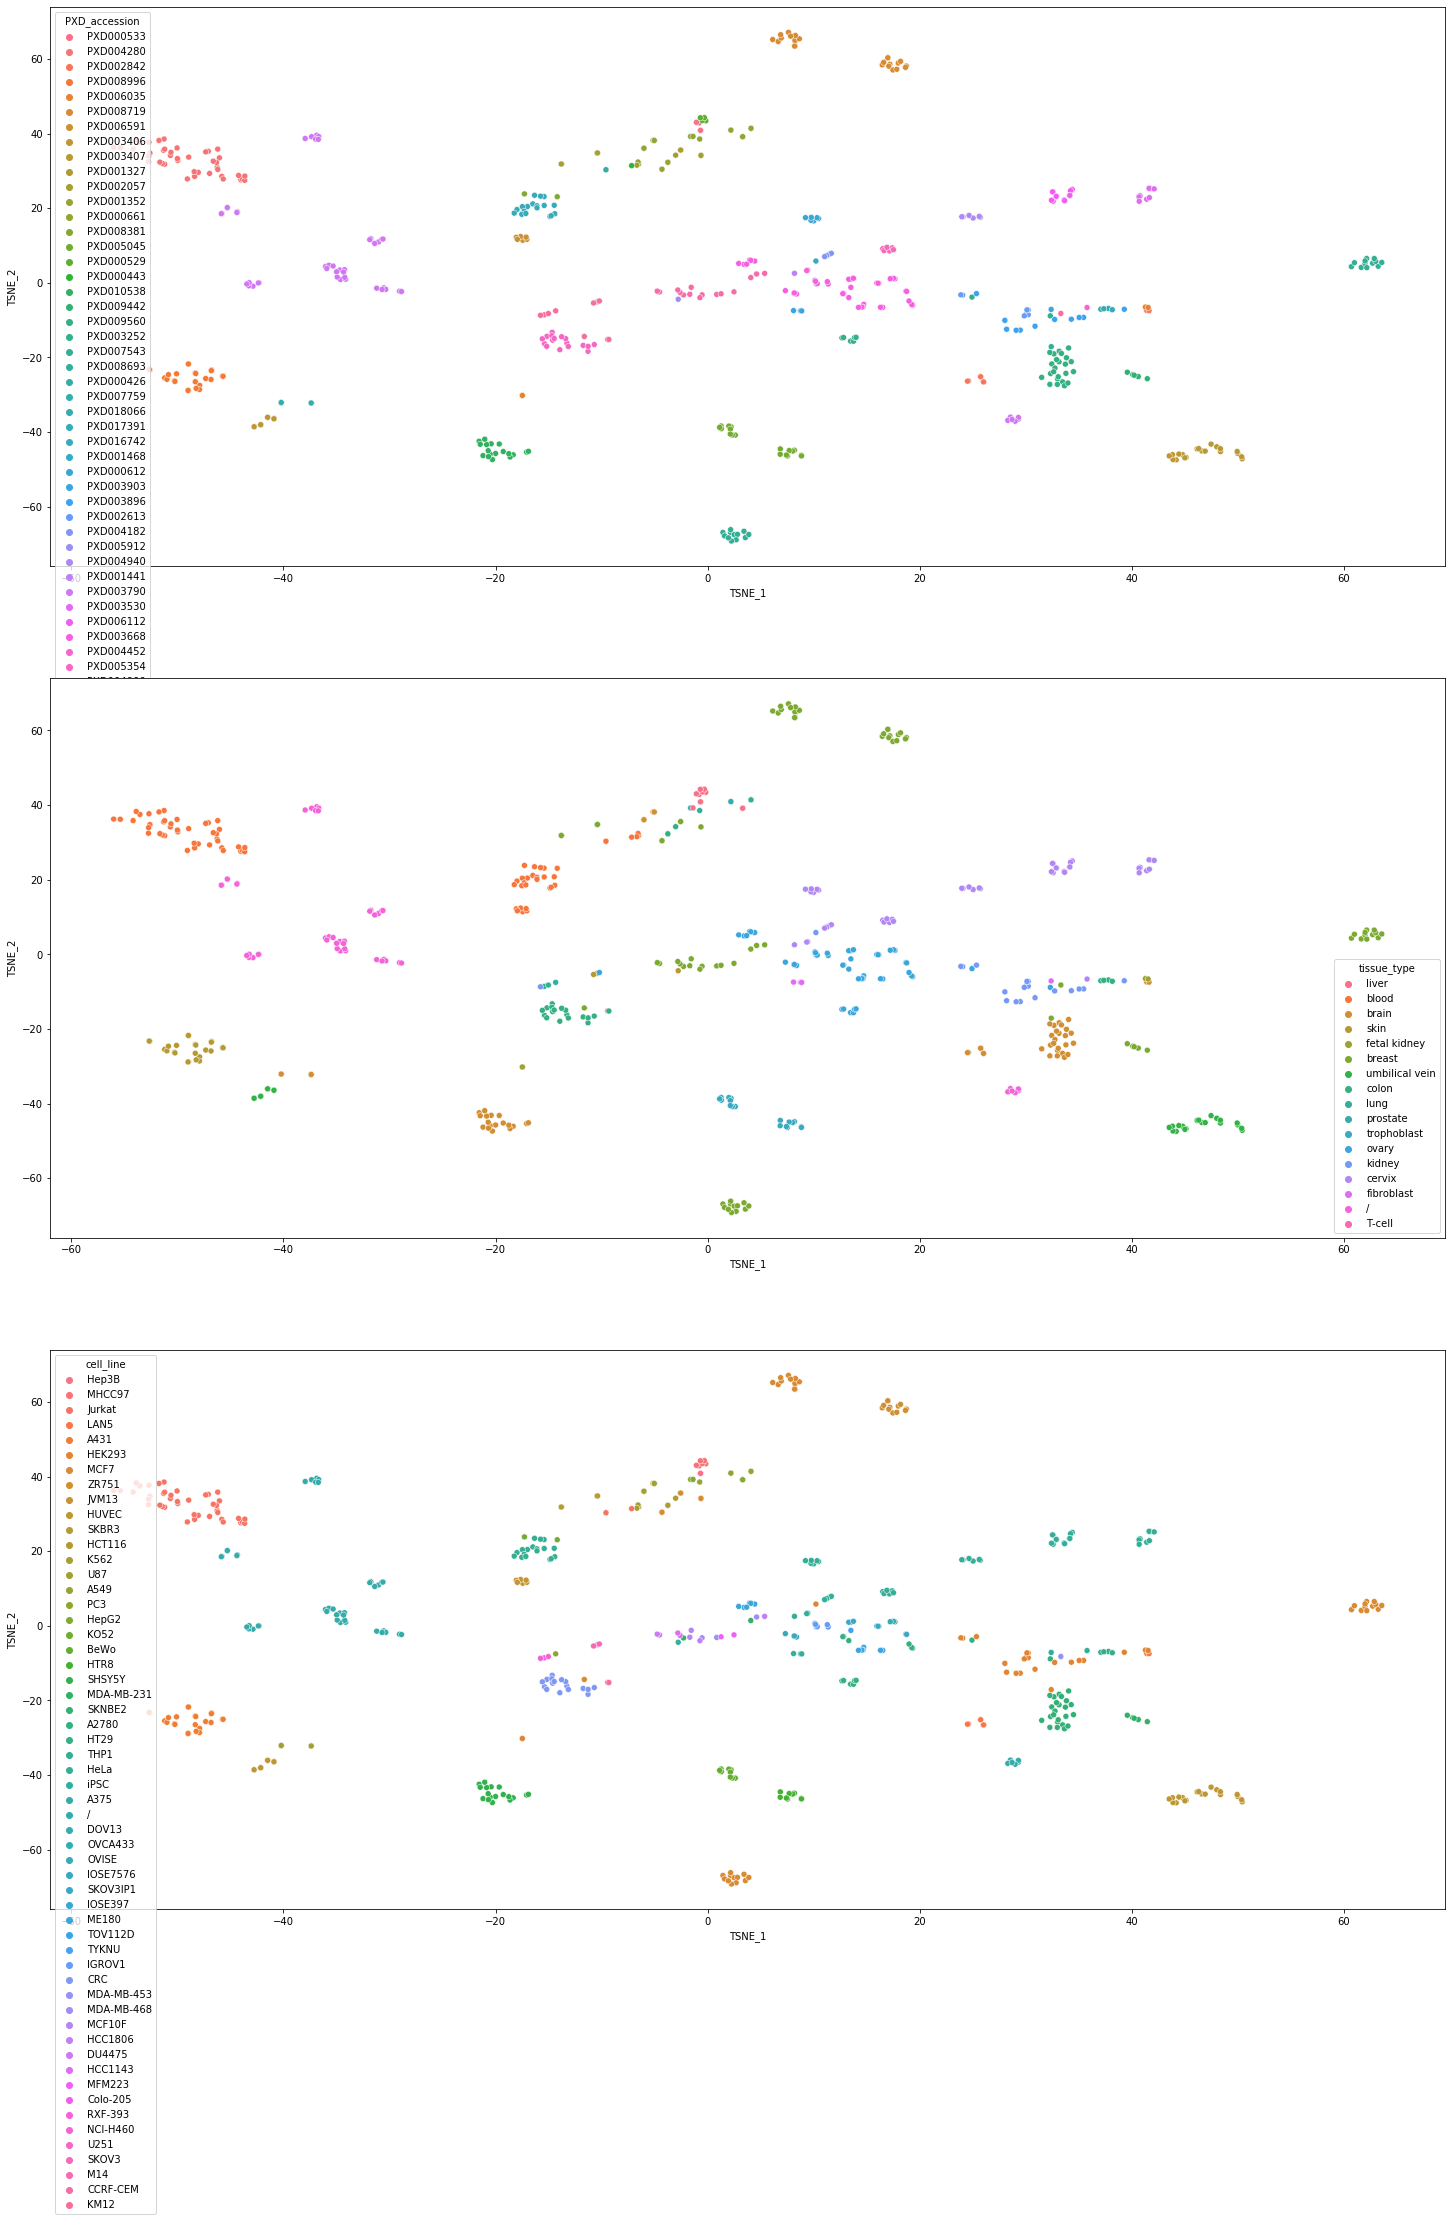

In [80]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 10)
tsne_results = tsne.fit_transform(filtered_dataset.fillna(0))
principalDf = pd.DataFrame(data = tsne_results, columns = ['TSNE_1', 'TSNE_2'])
    
finalDF = pd.concat([principalDf, metadata], axis = 1)
    
plt.figure(figsize = (25,35))
plt.subplot(311)
sns.scatterplot(data=finalDF, x='TSNE_1', y='TSNE_2', hue='PXD_accession')
plt.subplot(312)
sns.scatterplot(data=finalDF, x='TSNE_1', y='TSNE_2', hue='tissue_type')
plt.subplot(313)
sns.scatterplot(data=finalDF, x='TSNE_1', y='TSNE_2', hue="cell_line")

### 2.2 Only on train set

## 3. Evaluating reoccuring protein filtering

### 3.1 Randomly assigning samples to artificial classes

#### 3.1.1 On complete dataset

#### 3.1.2 Only on train set